<h1>ЛР №1 по дисциплине "Моделирование и предсказание поведения агентов финансовых систем"</h1>
<h2><i>Выполнил: Рейбандт А.А., J42113</i></h2>

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns

import os
import gc

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, f1_score

In [2]:
ls data/

alfabattle2_sand_alfabattle2_train_target.csv
part_000_0_to_23646.parquet
part_001_23647_to_47415.parquet
part_002_47416_to_70092.parquet
part_003_70093_to_92989.parquet
part_004_92990_to_115175.parquet


In [3]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 2, 
                                    columns=None, 
                                    verbose=False,
                                    info_num_parts=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    list_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    if info_num_parts:
        print(f'Кол-во партиций в папке: {len(list_paths)}')
    start_from = max(0, start_from)
    list_path_to_partitions = list_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for path_to_partition in list_path_to_partitions:
            print(path_to_pirtition)
    for path_to_parquet in tqdm.tqdm_notebook(list_path_to_partitions, 
                                              desc="Читаем файлы:"):
        temp_parquet = pd.read_parquet(path_to_parquet,columns=columns)
        res.append(temp_parquet)
        del temp_parquet
        gc.collect()
    return pd.concat(res).reset_index(drop=True)

In [4]:
PATH_TO_TRAIN = './data'

df = read_parquet_dataset_from_local(PATH_TO_TRAIN, 
                                     start_from=0, 
                                     num_parts_to_read=5,
                                     info_num_parts=True)

Кол-во партиций в папке: 5


Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

In [5]:
df.shape

(27045150, 20)

In [6]:
df.head()

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
0,0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,351,34,-1,1
1,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,351,34,0,2
2,0,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,351,34,0,3
3,0,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,348,34,52,4
4,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,337,53,280,5


In [24]:
print(f"Общее количество уникальных пользователей в выборке: {len(df['app_id'].unique())}")

Общее количество уникальных пользователей в выборке: 110700


<h1>Часть 1: профили пользователей</h1>

<h2>Профили временной активности для каждого пользователя<h2>

In [38]:
def get_activity_profile(period):
    return pd.pivot_table(df, values='transaction_number', index='app_id', columns=period, 
               aggfunc='count', fill_value=0)

* <font size="4">суточный (по часам):</font>

In [133]:
hour_df = get_activity_profile(period='hour')

In [49]:
hour_df

hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
app_id,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,3,5,9,8,13,25,11,17,12,23,10,16,19,7,1,0,1
1,4,0,0,0,0,0,0,1,39,15,20,32,14,25,33,17,20,23,14,14,31,42,10,2
2,8,0,4,0,1,0,1,2,3,6,7,9,11,13,15,15,8,12,24,18,24,22,17,9
3,1,0,6,0,0,0,0,3,4,2,5,1,6,3,7,1,3,8,5,3,4,2,1,2
4,0,0,0,0,0,1,13,17,1,0,0,0,10,14,5,7,6,13,11,10,3,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115171,1,1,0,0,0,0,2,0,5,18,22,55,58,127,71,81,73,81,59,37,31,18,5,1
115172,0,0,0,0,0,1,1,1,0,0,0,3,4,3,10,10,7,3,8,4,7,2,0,0
115173,3,0,6,1,1,0,7,8,11,14,7,11,24,20,17,14,7,3,8,11,0,5,12,0


In [144]:
# Проводим нормлаизацию значений
normalized_hour_df = StandardScaler().fit_transform(hour_df)

In [147]:
def kmeans_pipeline(data, activity_type) -> None:
    # Инициализируем алгоритм KMeans
    kmeans = KMeans(n_clusters=5, random_state=24)
    
    # Предсказываем лэйлблы кластеров
    label = kmeans.fit_predict(data)
    
    u_labels = np.unique(label)
    
    # Визуализируем результаты кластеризации пользователей
    for i in u_labels:
        plt.scatter(data[label == i , 0] , data[label == i , 1] , label=i)

    plt.xlabel('x', fontsize=15);
    plt.ylabel('y', fontsize=15);
    plt.title(f'Результаты кластеризации пользователей в зависимости от вида активности ({activity_type})\n', \
             fontsize=24)
    plt.rcParams["figure.figsize"] = (22,12)
    plt.grid('True')
    plt.legend()
    plt.show()
    
    centroids = kmeans.cluster_centers_
    # Визуализируем профили пользователей по центрам кластеров
    for i in range(len(centroids)):
        plt.plot(centroids[i], label=i)

    plt.xlabel(activity_type, fontsize=15);
    plt.ylabel('mean_normalized_value', fontsize=15);
    plt.title('Визуализация профилей пользователей по центрам кластеров'
              f' в зависимости от вида активности ({activity_type}) \n', \
             fontsize=24)
    plt.grid('True')
    plt.legend()
    plt.show()

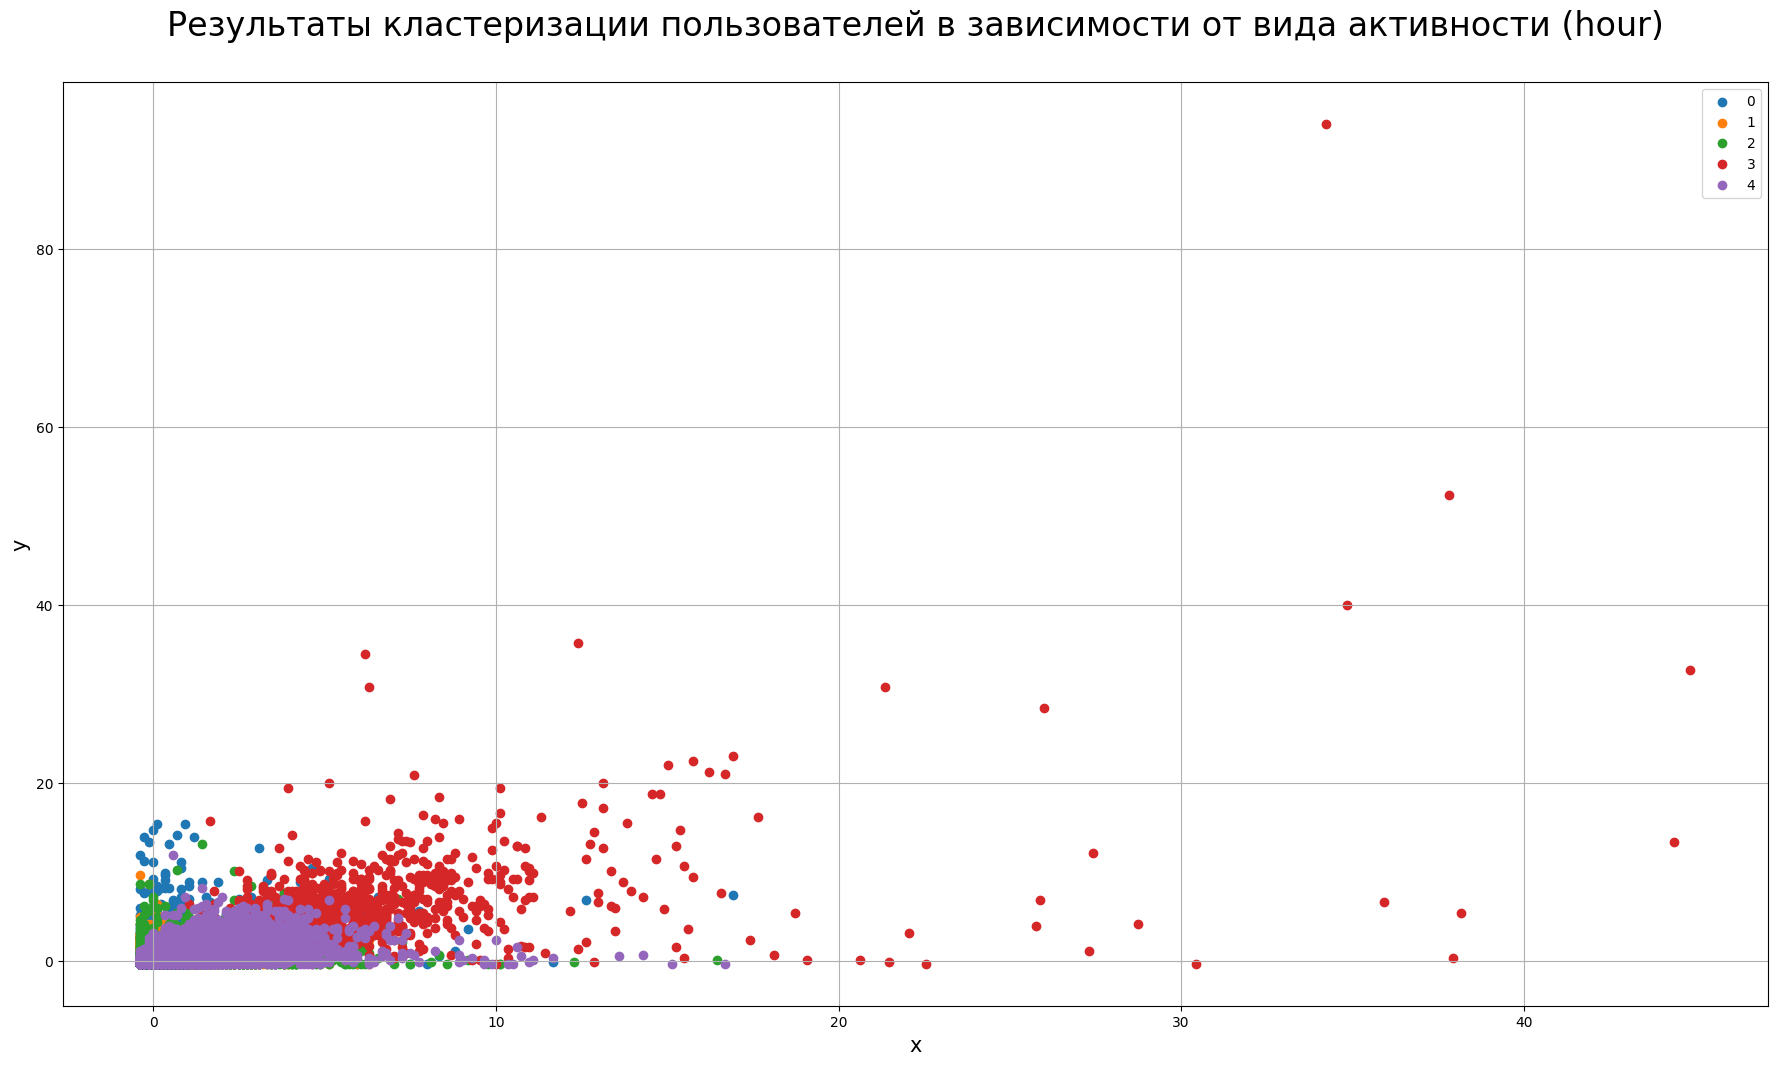

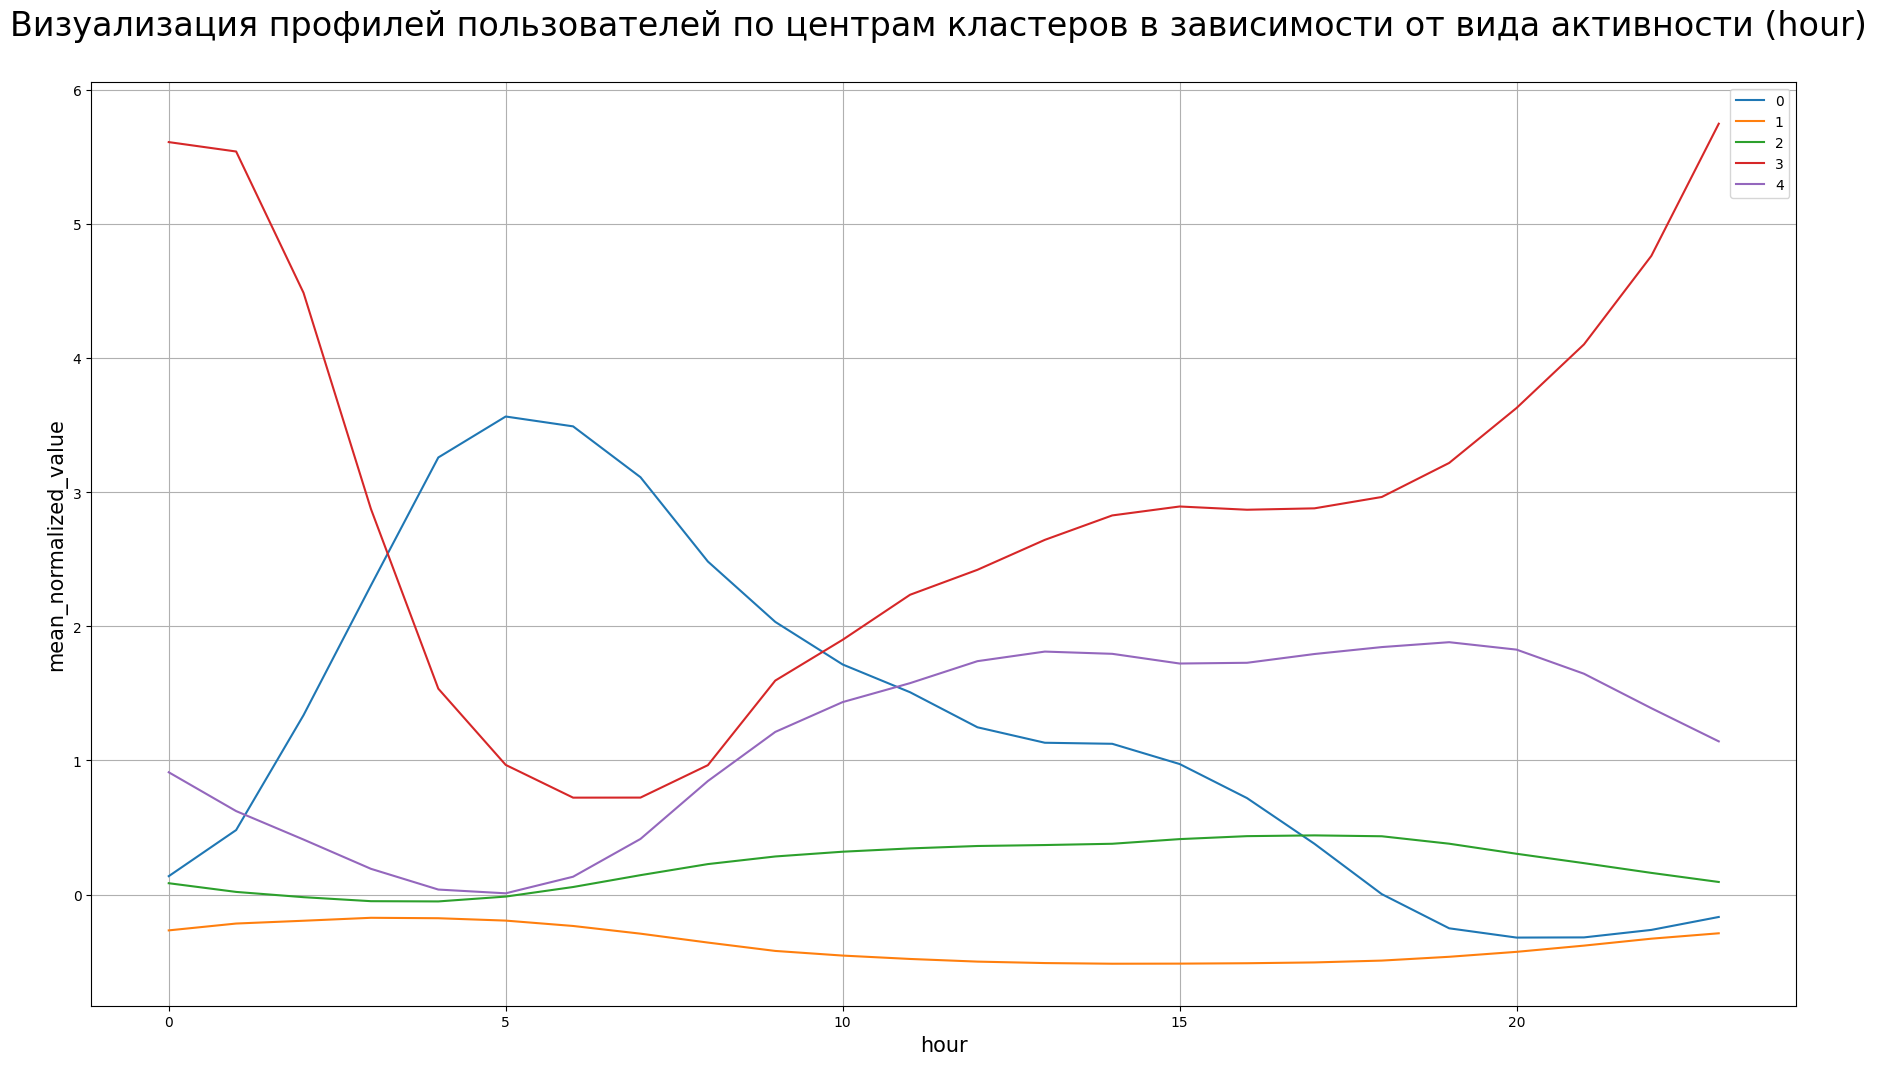

In [148]:
kmeans_pipeline(normalized_hour_df, 'hour')

<font size=4><b>Интерпретация: </b><i>пользователи, отнесенные к красному кластеру, склонны совершать наибольшее количество транзакций с пиками в начале и конче дня, в то время, как наблюдается также категория клиентов, для которой характерно наличие большого количества переводов/списаний по утрам (синий кластер). Желтый кластер является самым малочисленным и по своей сути напоминает поведение пользователей из зеленого (т.е. в целом, можно было бы ограничиться 4-мя кластерами)</i></font>

* <font size="4"> недельный (по дням): </font>

In [41]:
day_df = get_activity_profile(period='day_of_week') 

In [42]:
day_df

day_of_week,1,2,3,4,5,6,7
app_id,,,,,,,
0,18,28,20,31,29,31,24
1,41,46,77,65,44,48,35
2,44,22,25,35,34,35,34
3,16,12,5,11,8,8,7
4,24,9,15,18,18,20,13
...,...,...,...,...,...,...,...
115171,105,124,127,101,87,104,98
115172,18,8,6,10,9,6,7
115173,33,42,16,20,21,34,24


In [113]:
# Проводим нормлаизацию значений
normalized_day_df = StandardScaler().fit_transform(day_df)

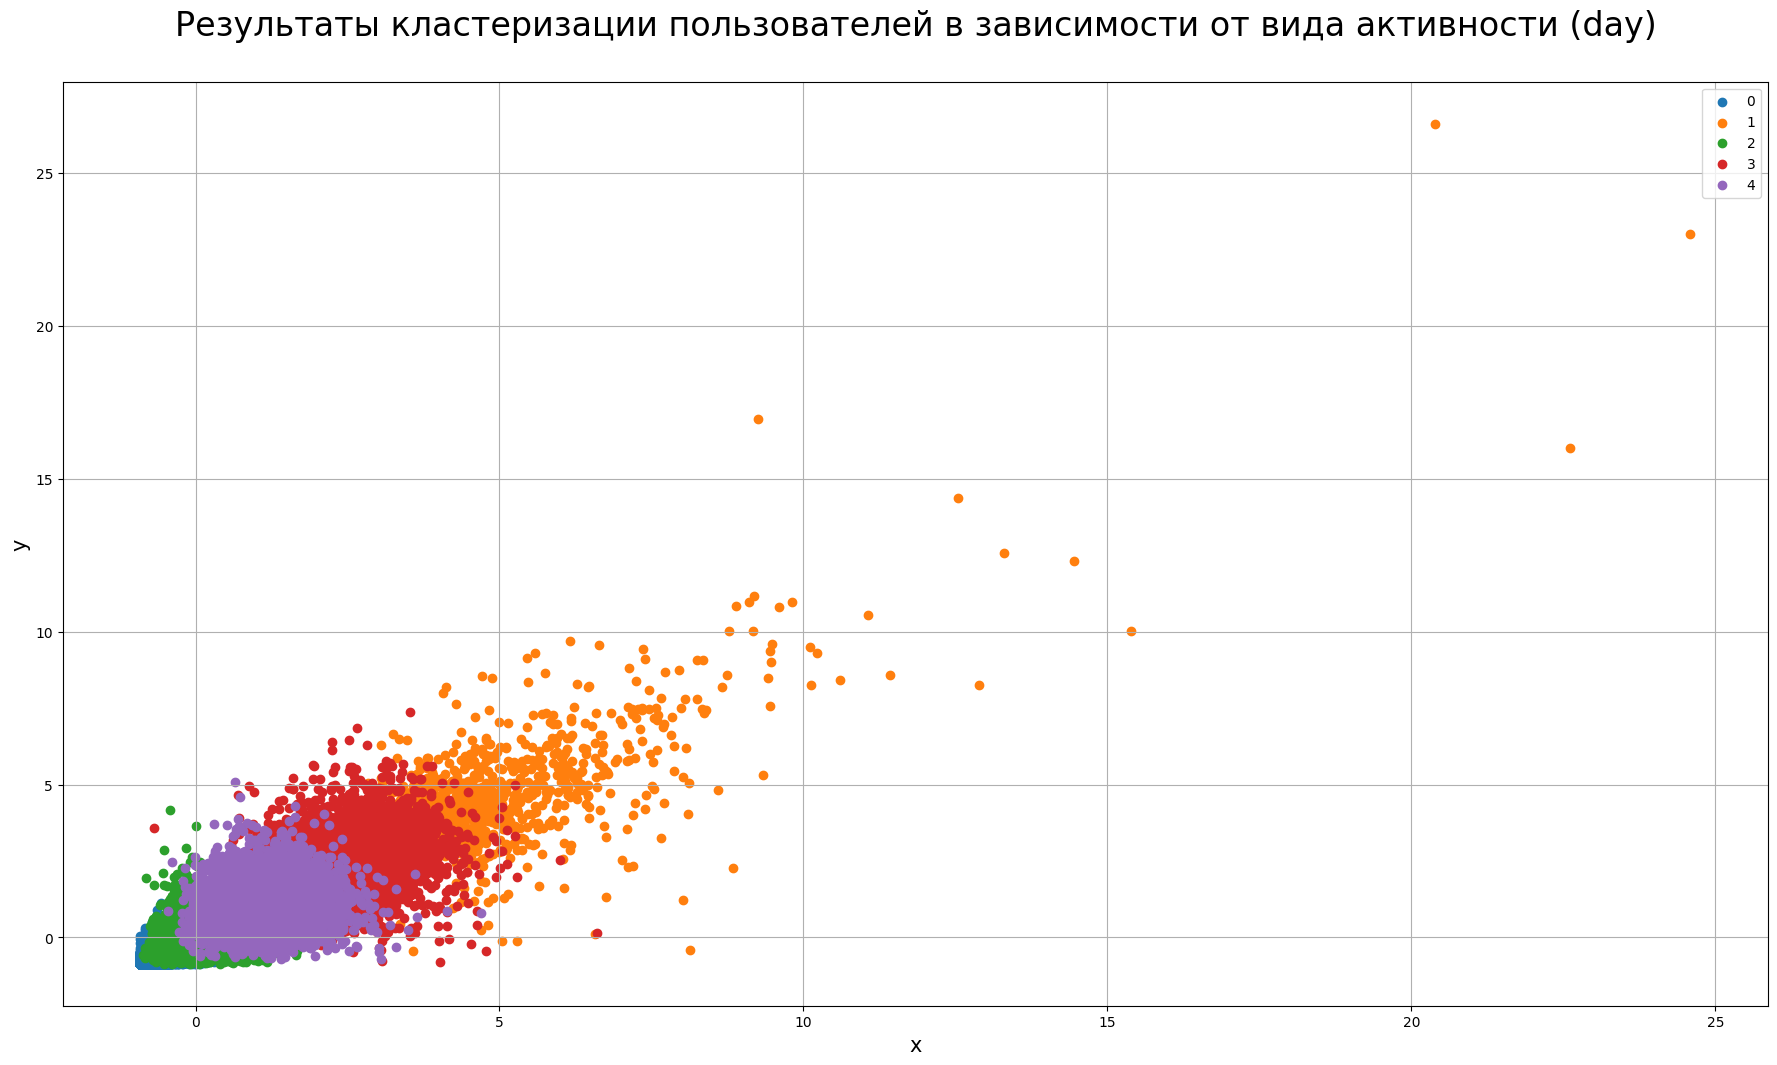

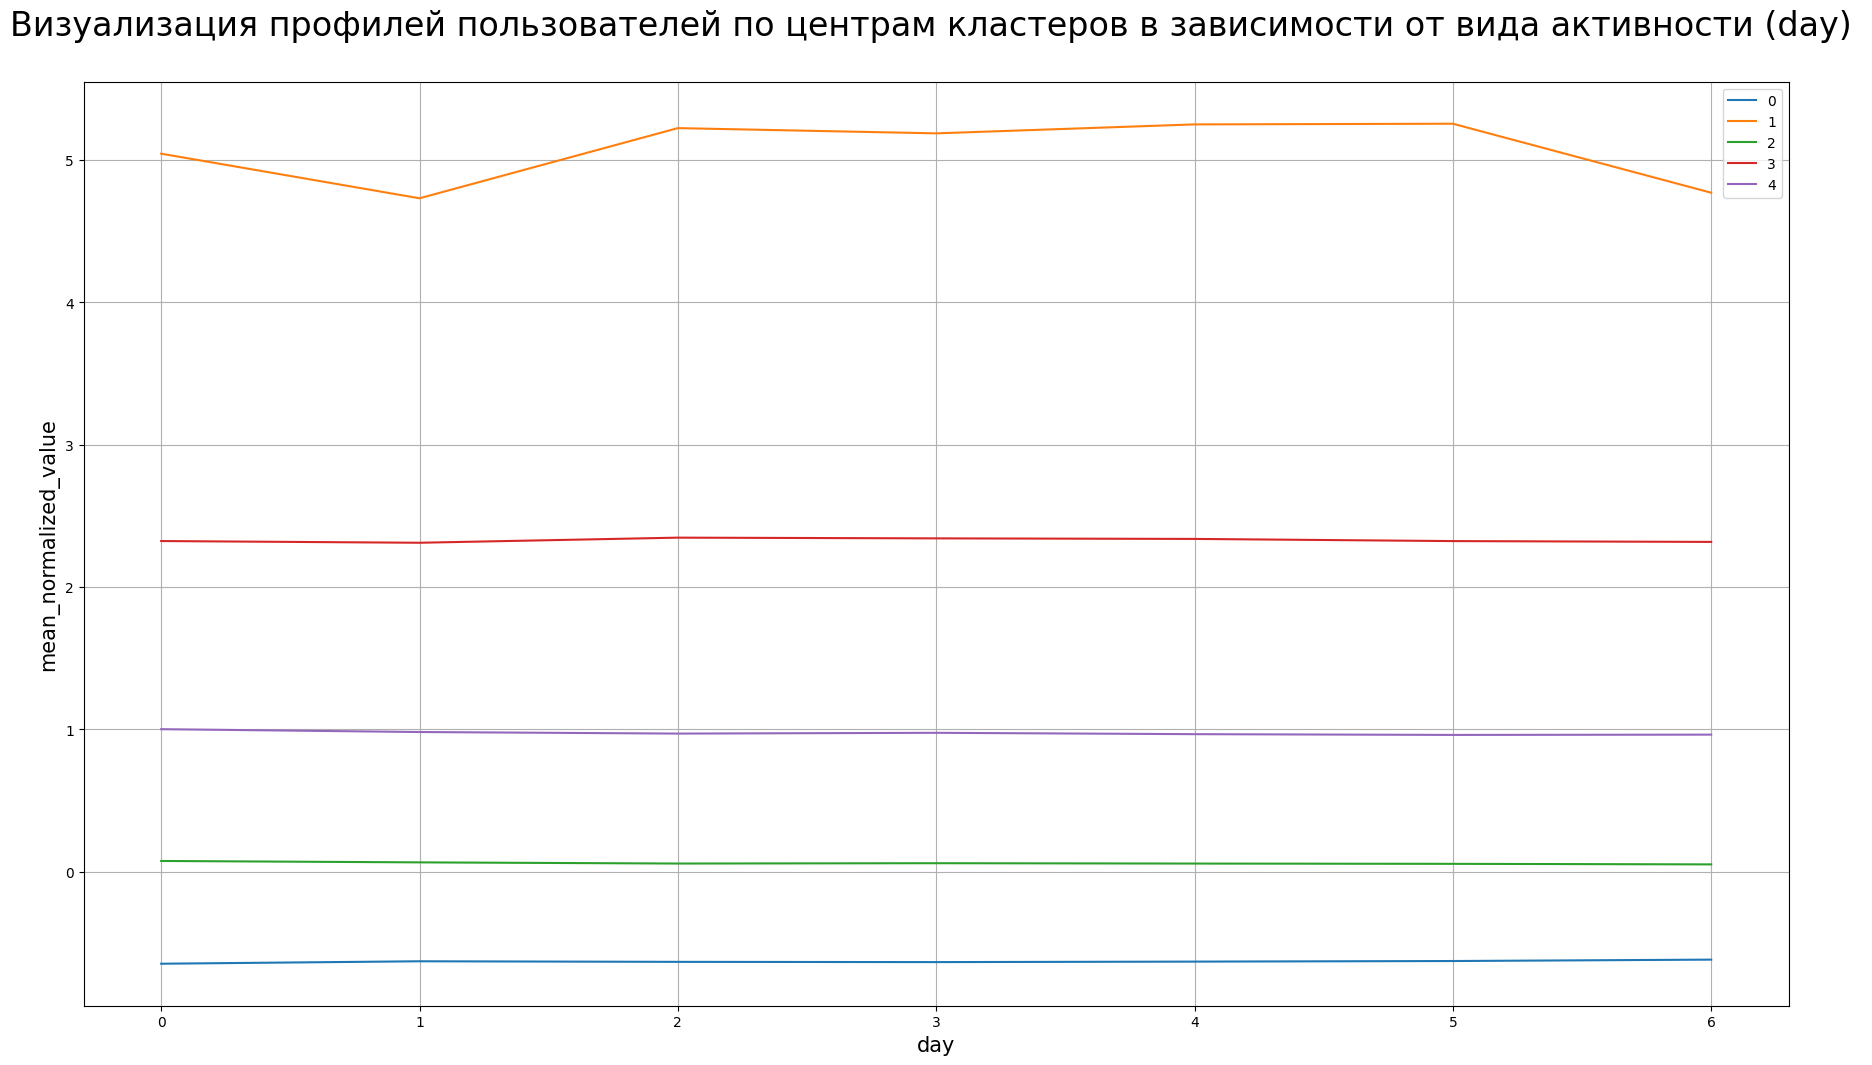

In [149]:
kmeans_pipeline(normalized_day_df, 'day')

<font size=4><b>Интерпретация: </b><i>в случае с дневной активностью имеем ситуацию, когда кластеры четко разделимы и обособленны друг от друга. Однако представители оранжевого кластера вносят наибольший шум в данные, причем их активность склонна падать по Вт и Вс.</i></font>

* <font size="4"> годовой (по месяцам): </font>

In [53]:
df['day_of_month'] = (df['day_of_week'] * df['weekofyear'] // 31 + 1)

In [54]:
month_df = get_activity_profile(period='day_of_month')

In [55]:
month_df

day_of_month,1,2,3,4,5,6,7,8,9,10,11,12
app_id,,,,,,,,,,,,
0,47,33,21,25,18,11,9,6,4,1,3,3
1,52,67,57,50,44,16,22,16,12,7,6,7
2,51,43,24,26,34,15,10,9,6,10,0,1
3,21,12,13,7,1,2,0,1,3,7,0,0
4,26,29,10,11,14,2,4,9,0,4,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...
115171,149,155,115,79,91,39,36,21,29,20,7,5
115172,17,13,6,3,7,1,7,1,3,5,1,0
115173,49,41,34,17,11,11,11,3,4,5,4,0


In [118]:
# Проводим нормлаизацию значений
normalized_month_df = StandardScaler().fit_transform(month_df)

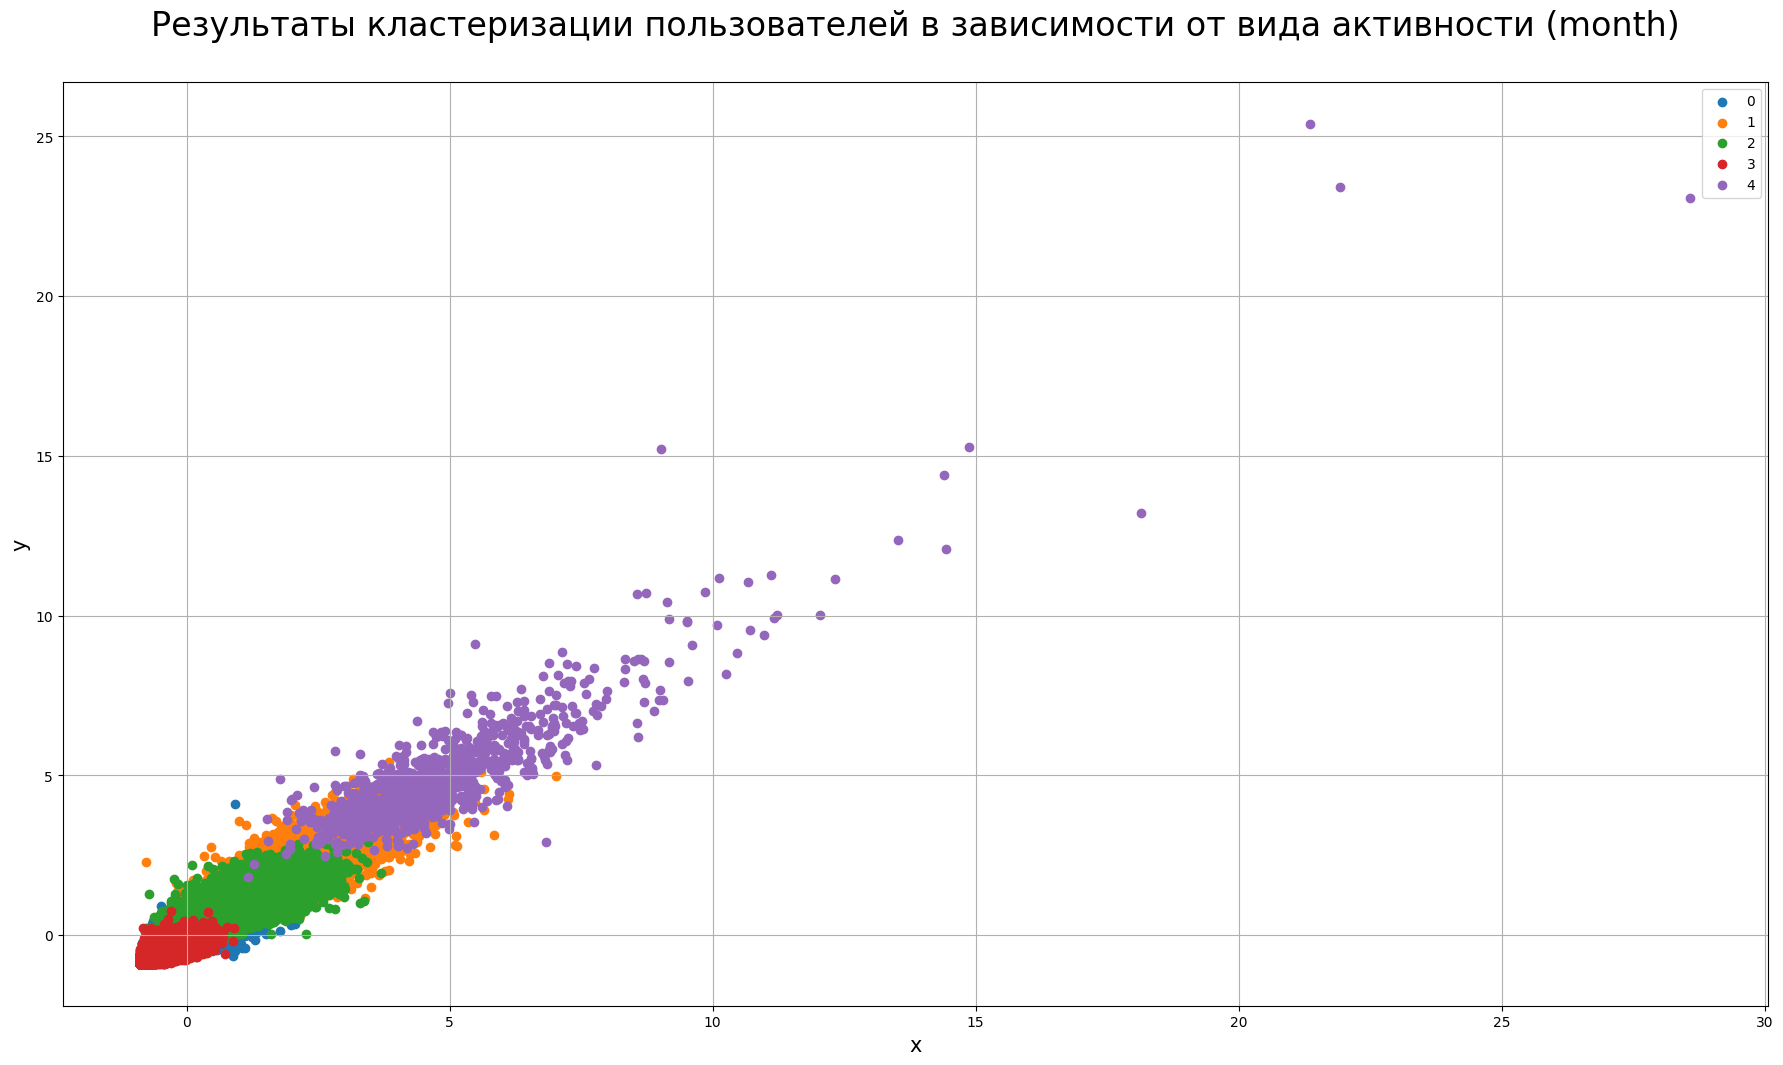

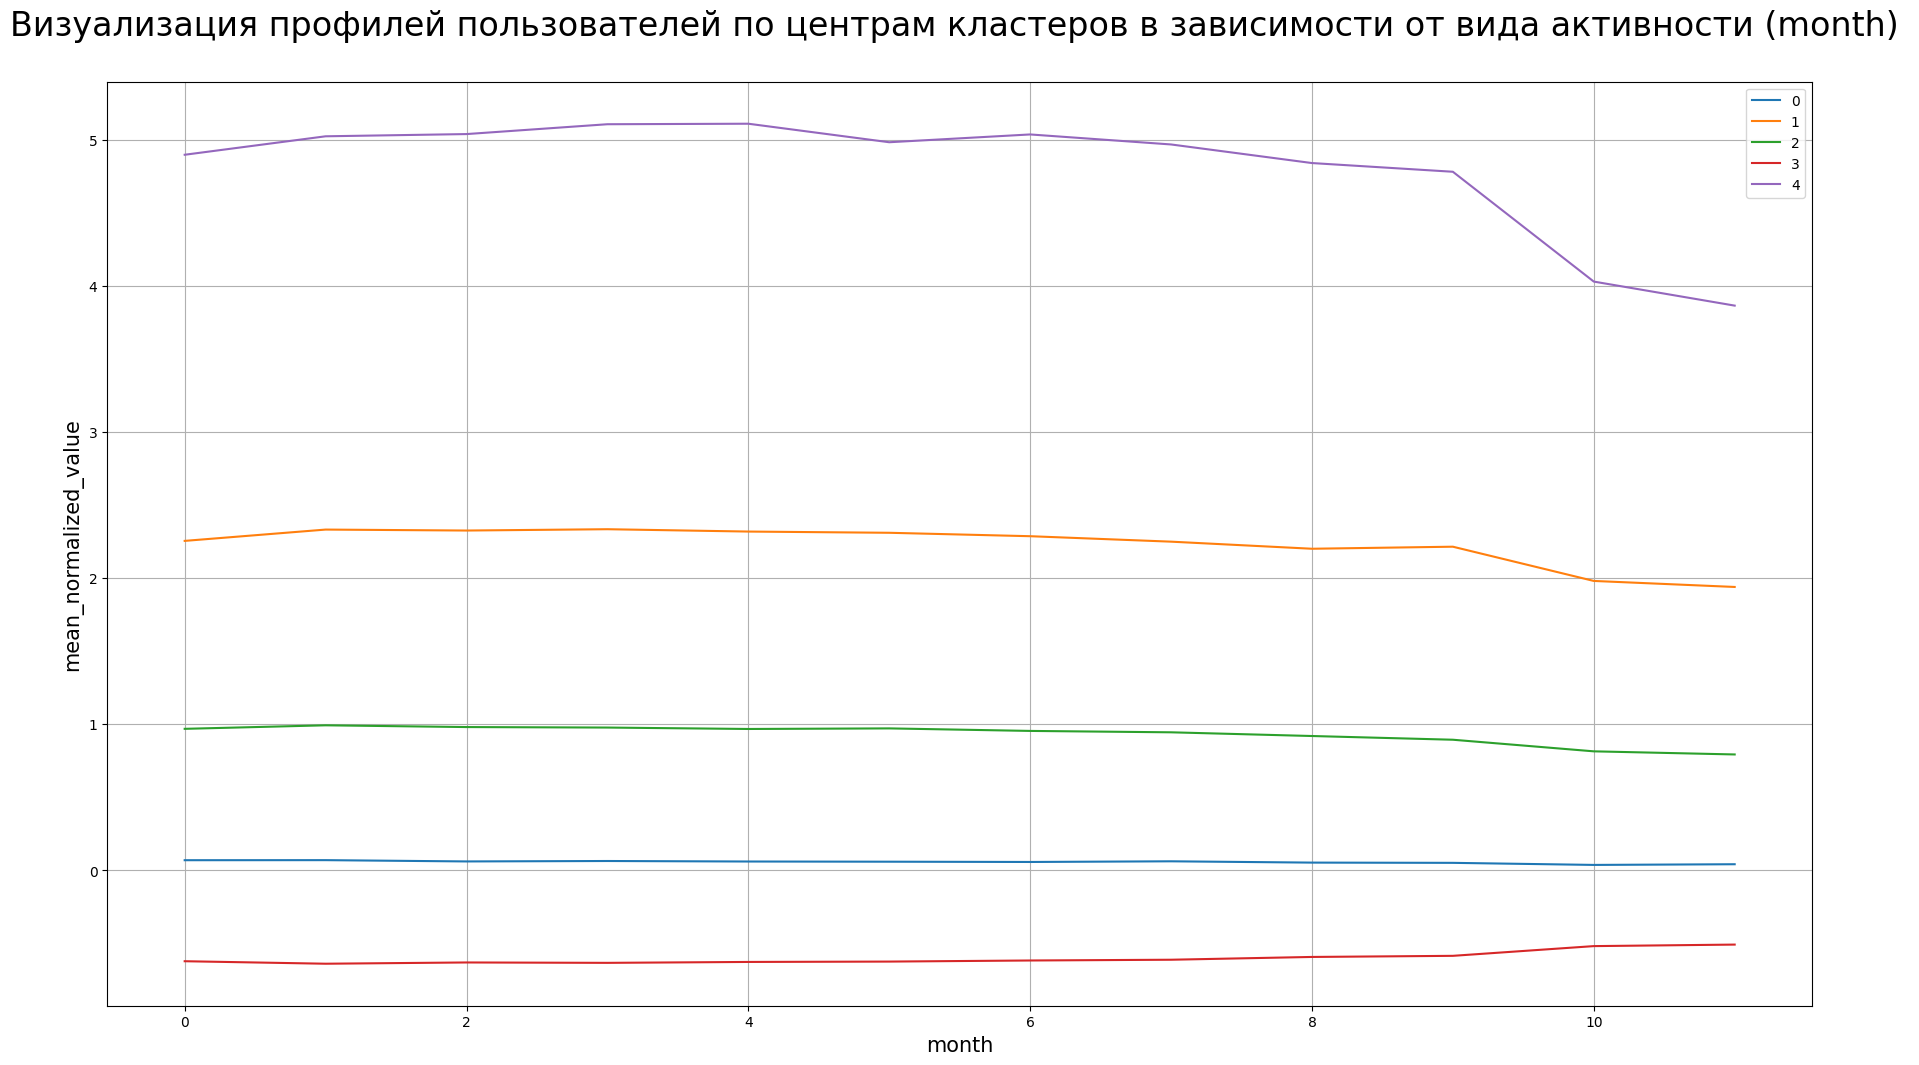

In [150]:
kmeans_pipeline(normalized_month_df, 'month')

<font size=4><b>Интерпретация: </b><i>кластеры по годовой активности сильно напоминают нам ситуацию с дневной за исключением того момента, что количество транзакций у наиболее активных пользователей склонно уменьшаться к концу года.</i></font>

<h2>Профили клиентов по тратам<h2>

In [120]:
df.head()

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,country,city,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number,day_of_month
0,0,0.465425,1,4,98,4,2,3,7,3,2,1,37,2,4,19,351,34,-1,1,5
1,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,20,351,34,0,2,5
2,0,0.521152,1,2,98,3,1,3,7,3,2,1,37,2,4,20,351,34,0,3,5
3,0,0.356078,1,1,5,2,1,3,7,3,10,1,49,7,2,0,348,34,52,4,3
4,0,0.000000,1,2,98,7,1,3,7,3,2,1,49,2,4,16,337,53,280,5,7


In [121]:
df['operation_kind'].unique()

array([4, 2, 1, 3, 6, 5, 7], dtype=int32)

In [122]:
operation_kind_df = get_activity_profile(period='operation_kind')

In [123]:
operation_kind_df.head()

operation_kind,1,2,3,4,5,6,7
app_id,,,,,,,
0,68,84,19,10,0,0,0
1,258,89,0,9,0,0,0
2,159,26,15,0,0,29,0
3,50,12,5,0,0,0,0
4,32,15,70,0,0,0,0


In [124]:
normalized_operation_kind_df = StandardScaler().fit_transform(operation_kind_df)

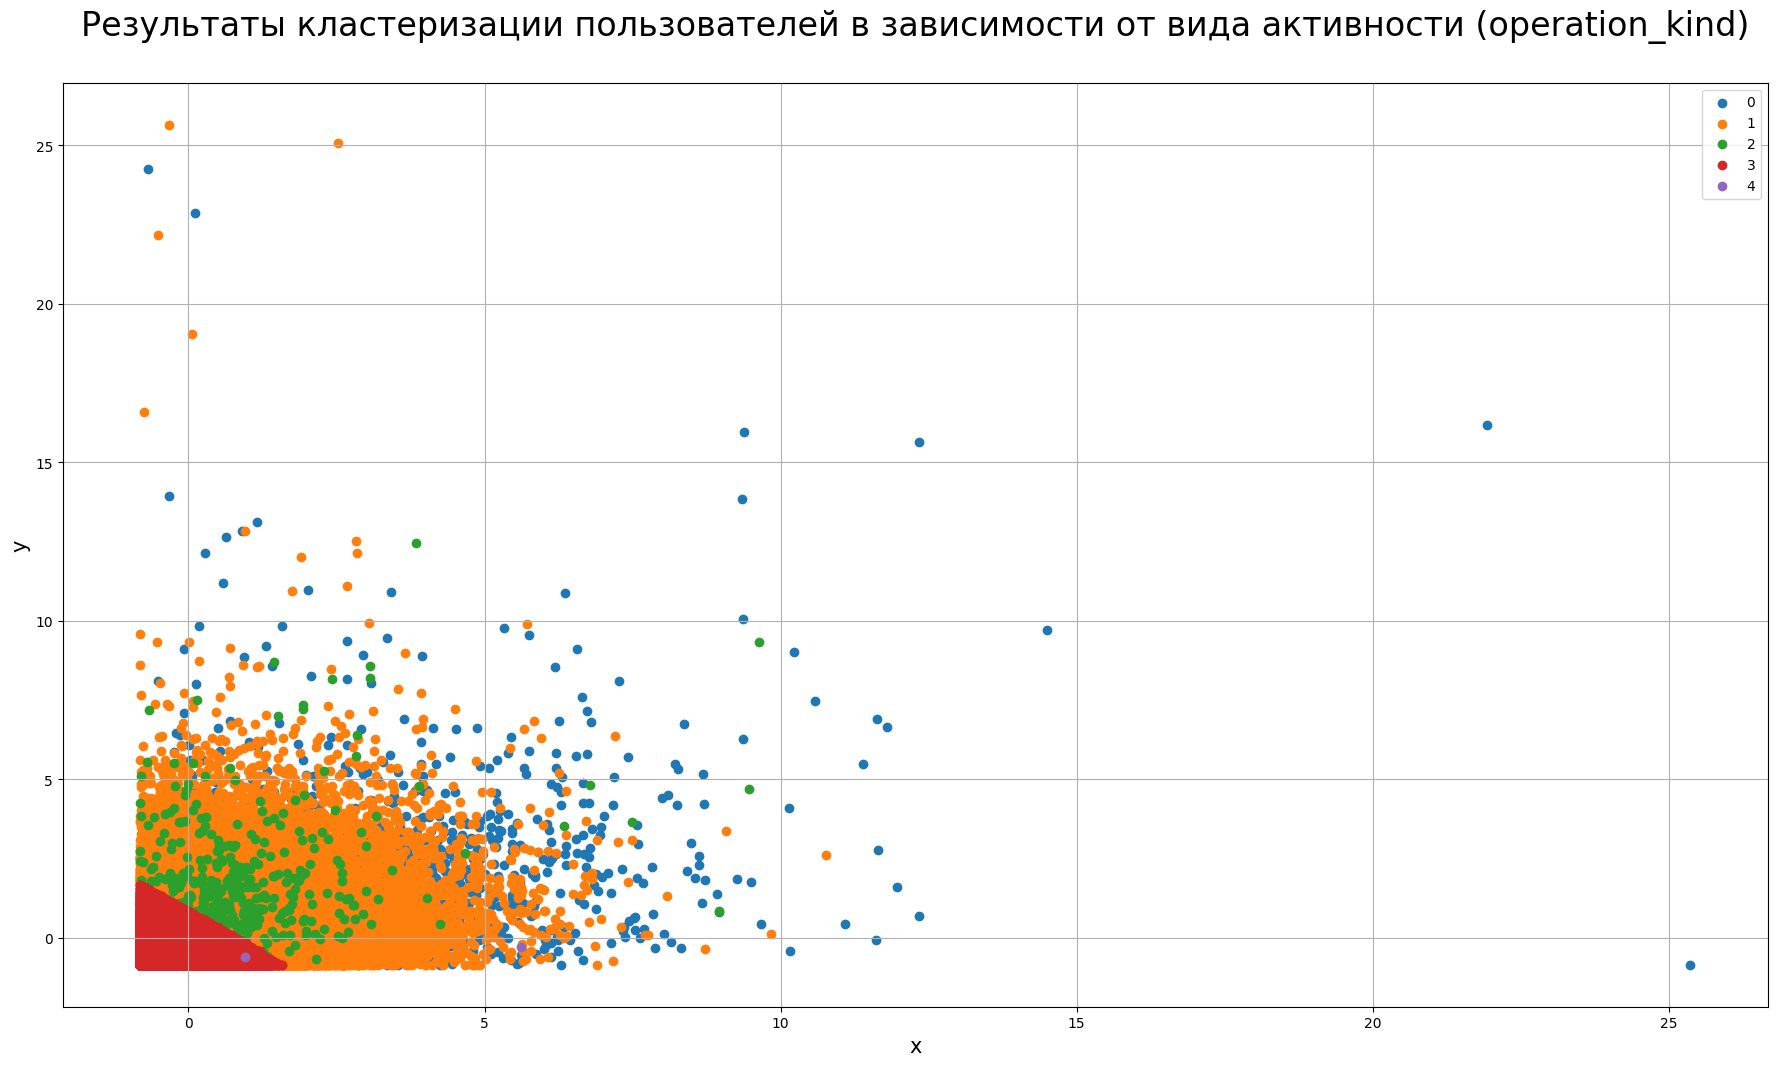

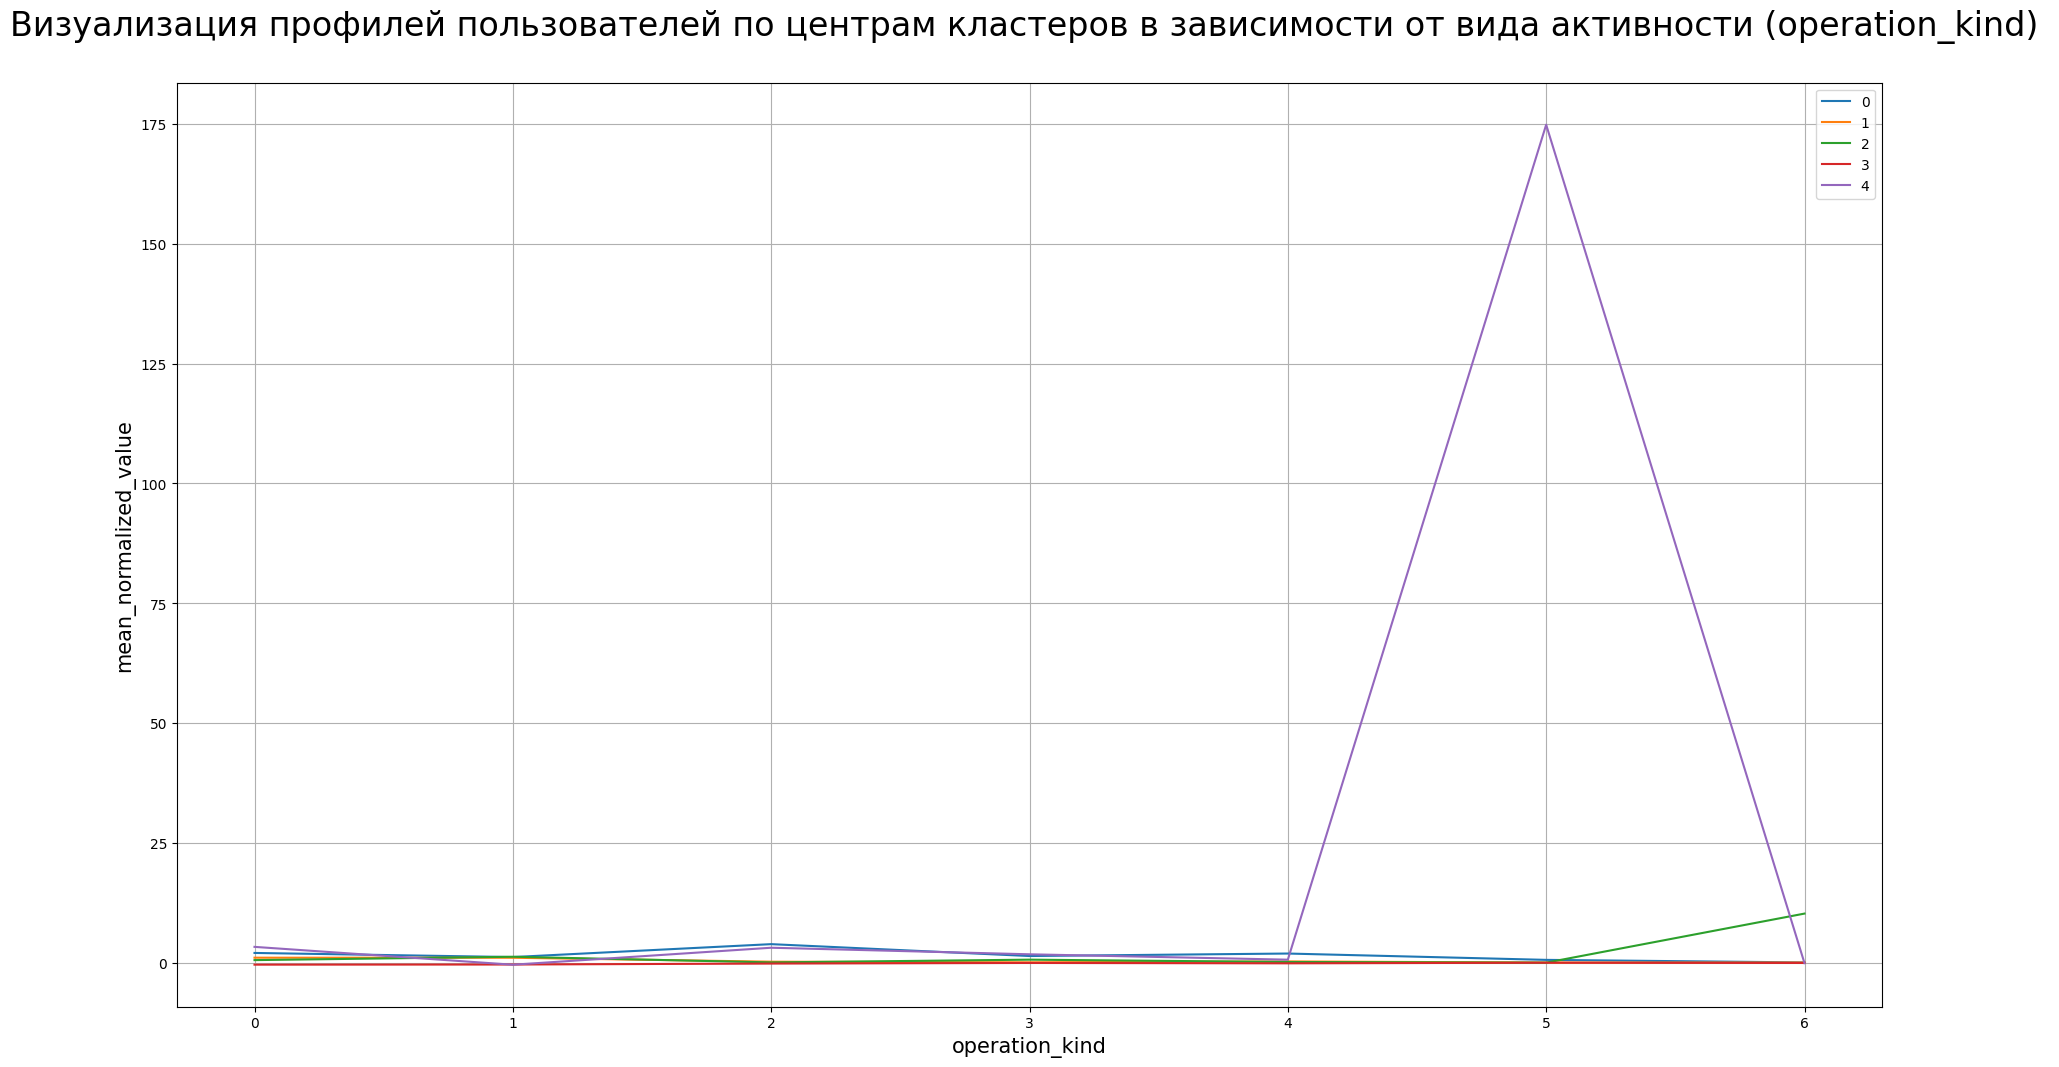

In [151]:
kmeans_pipeline(normalized_operation_kind_df, 'operation_kind')

<font size=4><b>Интерпретация: </b><i>кластеры клиентов, отражающие их поведение в вопросе трат, часто пересекаются, что говорит о совершении одним и тем же клиентом различных типов операций. Также из графиков видно, что есть кластер, в котором явно "выстреливают" типы трат, обозначенные идентификатором 5.</i></font>

<h2>Профили интересов, опираясь на mcc-коды транзакций</h2>

In [128]:
mcc_df = get_activity_profile(period='mcc')

In [129]:
mcc_df.head()

mcc,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108
app_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,25,94,1,1,0,0,0,13,15,9,4,0,0,0,0,2,0,0,1,4,0,2,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0
1,82,98,24,21,1,0,20,0,0,20,0,0,0,0,2,0,5,0,0,49,0,1,0,0,4,0,0,0,0,2,0,1,0,3,2,0,2,0,0,0,0,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,10,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,86,26,1,2,0,0,8,0,12,0,3,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,11,12,0,5,6,14,0,1,5,6,0,0,0,0,1,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,15,0,0,0,0,0,0,71,0,1,0,0,0,0,0,0,0,0,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [130]:
normalized_mcc_df = StandardScaler().fit_transform(mcc_df)

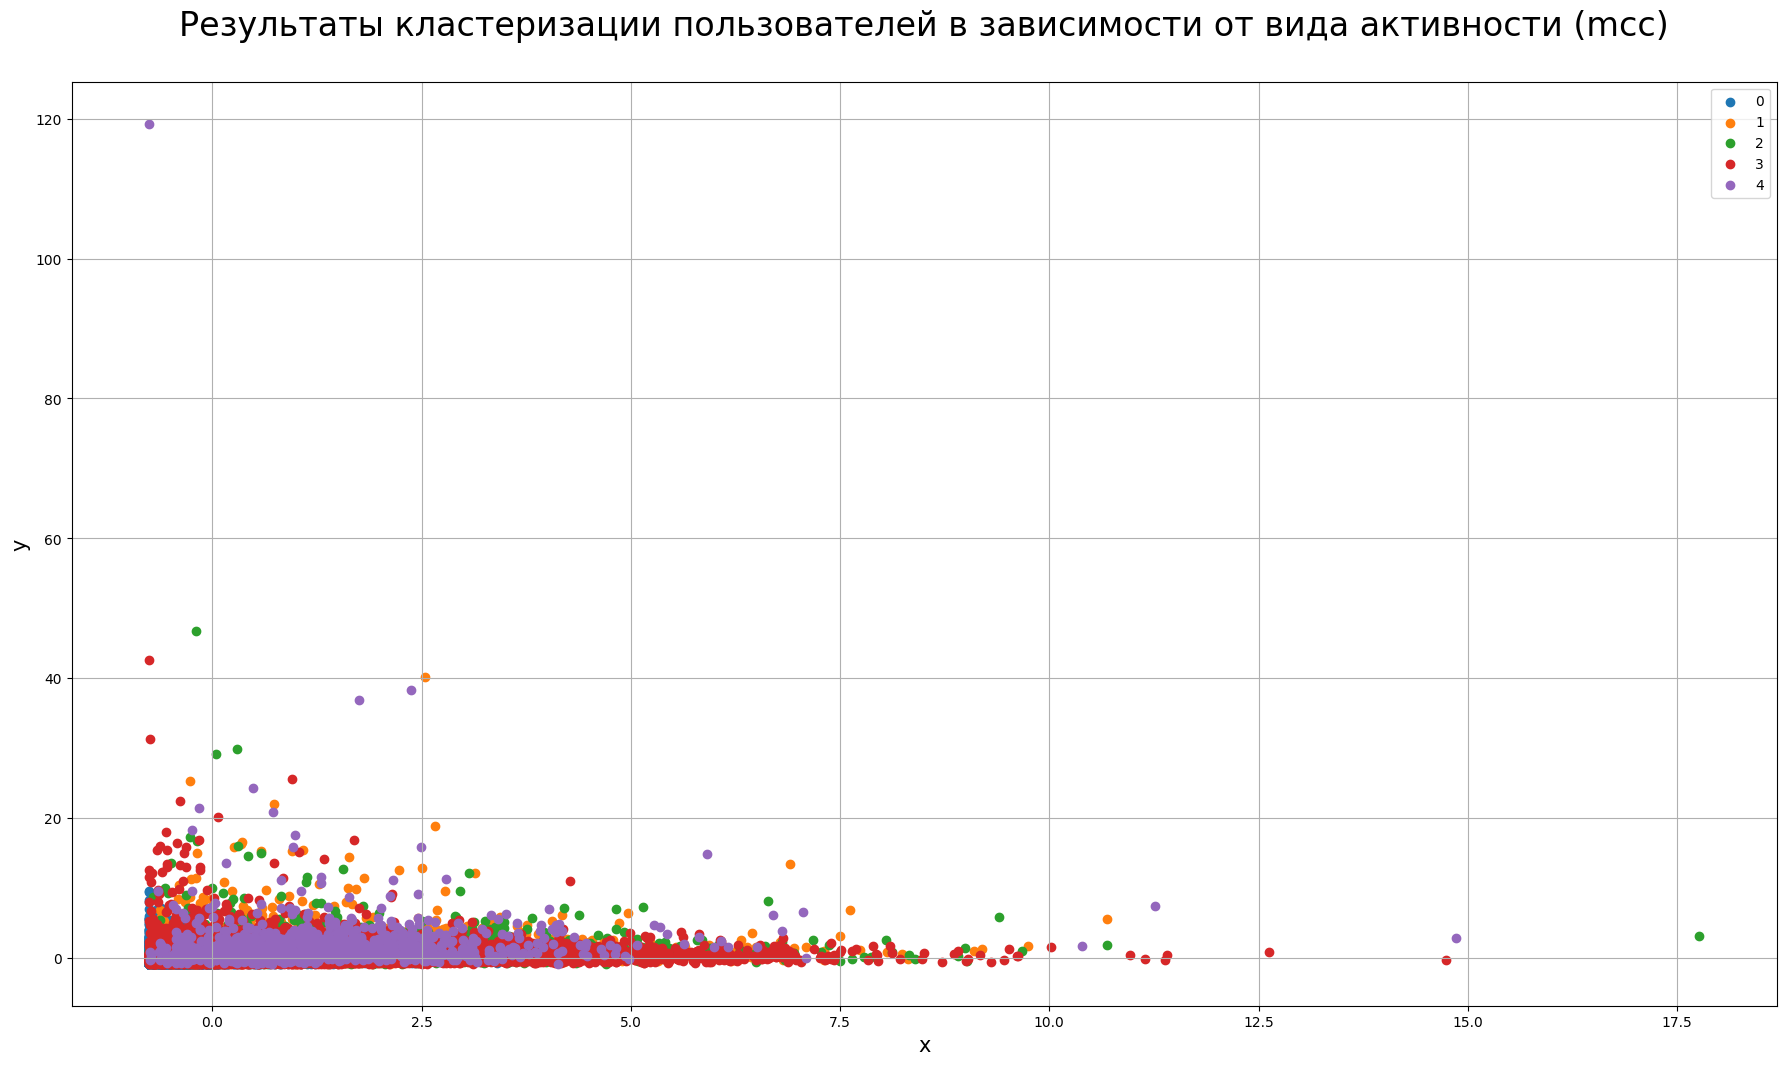

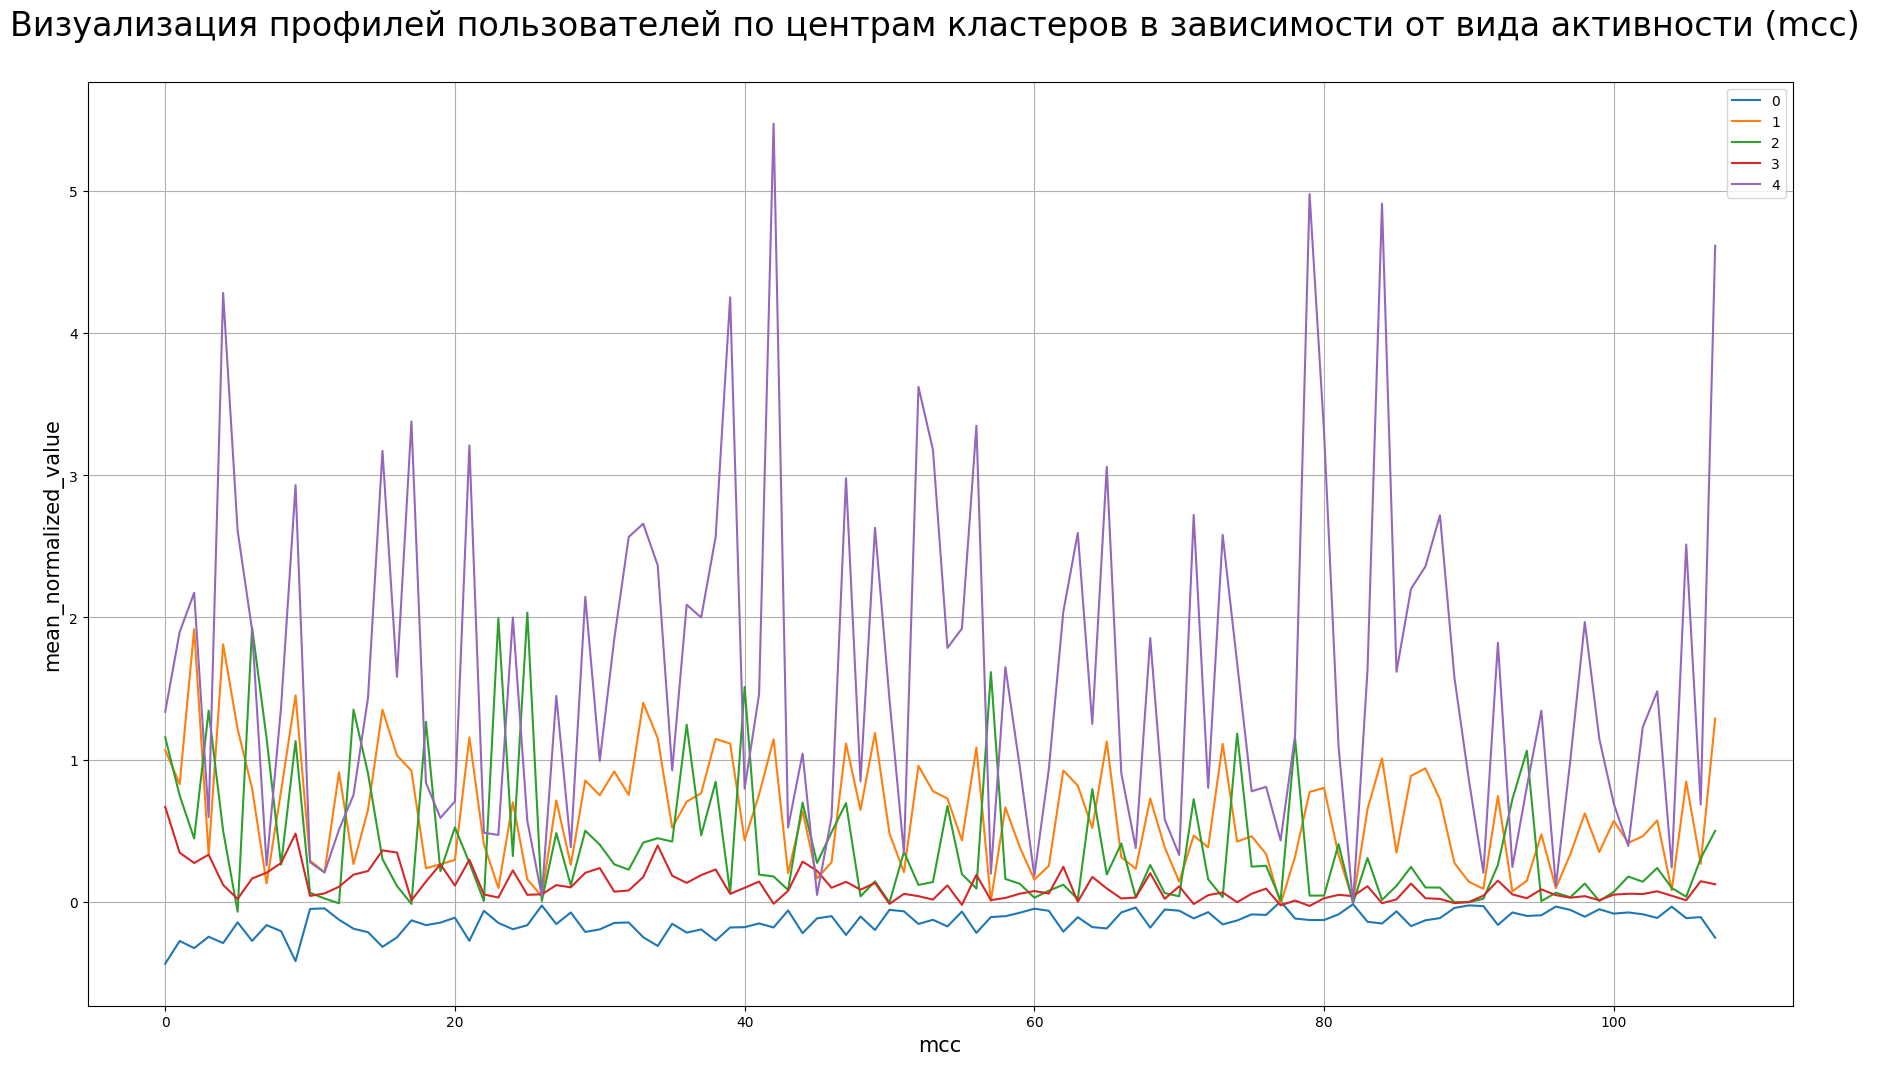

In [152]:
kmeans_pipeline(normalized_mcc_df, 'mcc')

<font size=4><b>Интерпретация: </b><i>Результаты кластеризации по mcc-кодам дают нам понять специфику кластеров - а именно тот факт, что несмотря на многообразие значений по оси абцисс, кластеры как бы "прибиты" к оси ординат. Центры же кластеров позволяют определить наиболее интересные тем или иным категориям клиентов типы товаров: в частности, пользователям из фиолетового кластера можно будет рекомендовать товары с mcc-кодом 8, 38, 43, 78, 84 и 108.</i></font>

<h1>Часть 2: скоринг</h1>

In [21]:
train_targets = pd.read_csv("./data/alfabattle2_sand_alfabattle2_train_target.csv")

In [22]:
train_targets.head()

,app_id,product,flag
0,0,3,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


<font size=4><b> Инициализируем вспомогательные функции, чтобы поместить такой большой объем parquet-файлов в память

In [18]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 2, 
                                    columns=None, 
                                    verbose=False,
                                    info_num_parts=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    list_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    if info_num_parts:
        print(f'Кол-во партиций в папке: {len(list_paths)}')
    start_from = max(0, start_from)
    list_path_to_partitions = list_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for path_to_partition in list_path_to_partitions:
            print(path_to_pirtition)
    for path_to_parquet in tqdm.tqdm_notebook(list_path_to_partitions, 
                                              desc="Читаем файлы:"):
        temp_parquet = pd.read_parquet(path_to_parquet,columns=columns)
        res.append(temp_parquet)
        del temp_parquet
        gc.collect()
    return pd.concat(res).reset_index(drop=True)


def __amnt_pivot_table_by_column_as_frame(frame, column, agg_funcs=None) -> pd.DataFrame:
    """
    Строит pivot table для между колонкой `amnt`  и column на основе переданных aggregations_on
    :param frame: pd.DataFrame транзакций
    :param column: название колонки, на основе `amnt`  и column будет построен pivot_table
    :param agg_funcs: список из функций, которые нужно применить, по умолчанию ['mean', 'count']
    :return: pd.DataFrame
    """
    if agg_funcs is None:
        agg_funcs = ['mean', 'count']
    aggs = pd.pivot_table(frame, values='amnt',
                          index=['app_id'], columns=[column],
                          aggfunc={'amnt': agg_funcs},
                          fill_value=0.0)
    aggs.columns = [f'{col[0]}_{column}_{col[1]}' for col in aggs.columns.values]
    return aggs

def extract_basic_aggregations(transactions_frame: pd.DataFrame, 
                               cat_columns=None, 
                               agg_funcs=None) -> pd.DataFrame:
    """
    :param transactions_frame: pd.DataFrame с транзакциями
    :param cat_columns: список категориальных переменных, для которых будут построены агрегаты по `amnt`
    :param agg_funcs: список функций, который нужно применить для подсчета агрегатов, 
    :по умолчанию ['sum', 'mean', 'count']
    :return: pd.DataFrame с извлеченными признаками
    """
    if not cat_columns:
        cat_columns = CAT_COLUMNS

    pivot_tables = []
    for col in cat_columns:
        pivot_tables.append(__amnt_pivot_table_by_column_as_frame(transactions_frame, column=col,
                                                                  agg_funcs=agg_funcs))
    pivot_tables = pd.concat(pivot_tables, axis=1)

    aggs = {
        # посчитаем статистики для транзакций
        'amnt': ['mean', 'median', 'sum', 'std'],
        # посчитаем разумные агрегаты для разницы в часах между транзакциями
        'hour_diff': ['max', 'mean', 'median', 'var', 'std'],
        # добавим самую раннюю/позднюю и среднюю дату транзакции до подачи заявки на кредит
        'days_before': ['min', 'max', 'median']}

    numeric_stats = transactions_frame.groupby(['app_id']).agg(aggs)

    # дадим разумные имена новым колонкам; может не работать в python 3.5, так как порядок ключей в словаре не
    # гарантирован
    numeric_stats.columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

    return pd.concat([pivot_tables, numeric_stats], axis=1).reset_index()

def prepare_transactions_dataset(path_to_dataset: str, 
                                 num_parts_to_preprocess_at_once: int = 1, 
                                 num_parts_total: int=50, 
                                 save_to_path=None, 
                                 verbose: bool=False):
    """
    :возвращает готовый pd.DataFrame с признаками, на которых можно учить модель для целевой задачи.
    :path_to_dataset: str - путь до датасета с партициями
    :num_parts_to_preprocess_at_once: int - количество партиций, которые будут одновременно держаться в памяти и обрабатываться
    :num_parts_total: int - общее количество партиций, которые нужно обработать
    :save_to_path: str - путь до папки, в которой будет сохранен каждый обработанный блок в .parquet формате. Если None, то не будет сохранен 
    :verbose: bool - логирует каждый обрабатываемый кусок данных
    """
    preprocessed_frames = []
    block = 0
    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once), 
                                   desc="Общий прогресс препроцессинга:"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, 
                                                             step, 
                                                             num_parts_to_preprocess_at_once, 
                                                             verbose=verbose)
        features = extract_basic_aggregations(transactions_frame, 
                                              cat_columns=['mcc_category', 
                                                           'day_of_week', 
                                                           'operation_type'])
        if save_to_path:
            block_as_str = str(block)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            features.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))
            
        preprocessed_frames.append(features)
    return pd.concat(preprocessed_frames)

def reduce_mem_usage_df(d_df: pd.DataFrame)-> [pd.DataFrame, list]:
    """
    :перебирает все столбцы датафрейма и изменяет тип данных для уменьшения использования памяти.
    """
    start_mem = d_df.memory_usage().sum() / 1024**2
    print('Размер памяти исходного датафрейма {:.2f} MB'.format(start_mem))
    
    d_log = []
    for col in d_df.columns:
        col_type = d_df[col].dtype

        if col_type != object:
            c_min = d_df[col].min()
            c_max = d_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    d_df[col] = d_df[col].astype(np.int8)
                    d_log.append(f'{col} :from int64 to int8')
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    d_df[col] = d_df[col].astype(np.int16)
                    d_log.append(f'{col} :from int64 to int16')

    end_mem = d_df.memory_usage().sum() / 1024**2
    print('Размер памяти после оптимизации: {:.2f} MB'.format(end_mem))
    print('Уменьшено на {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print('Список внесенных изменений вы можете посмотреть в логе')
    
    return d_df, d_log

In [19]:
%%time
train_data = prepare_transactions_dataset(PATH_TO_TRAIN, 
                                    num_parts_to_preprocess_at_once=5, 
                                    num_parts_total=50)

Общий прогресс препроцессинга::   0%|          | 0/10 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1min 19s, sys: 51.2 s, total: 2min 11s
Wall time: 2min 7s


In [20]:
train_data, log_reduce_mem_train = reduce_mem_usage_df(train_data)

Размер памяти исходного датафрейма 933.87 MB
Размер памяти после оптимизации: 602.05 MB
Уменьшено на 35.5%
Список внесенных изменений вы можете посмотреть в логе


In [23]:
merged_train_data = train_data.merge(train_targets[['app_id', 'product', 'flag']], on=['app_id'])

In [24]:
merged_train_data.head()

,app_id,count_mcc_category_1,count_mcc_category_2,count_mcc_category_3,count_mcc_category_4,count_mcc_category_5,count_mcc_category_6,count_mcc_category_7,count_mcc_category_8,count_mcc_category_9,count_mcc_category_10,count_mcc_category_11,count_mcc_category_12,count_mcc_category_13,count_mcc_category_14,count_mcc_category_15,count_mcc_category_16,count_mcc_category_17,count_mcc_category_18,count_mcc_category_19,count_mcc_category_20,count_mcc_category_21,count_mcc_category_22,count_mcc_category_23,count_mcc_category_24,count_mcc_category_25,count_mcc_category_26,count_mcc_category_27,count_mcc_category_28,mean_mcc_category_1,mean_mcc_category_2,mean_mcc_category_3,mean_mcc_category_4,mean_mcc_category_5,mean_mcc_category_6,mean_mcc_category_7,mean_mcc_category_8,mean_mcc_category_9,mean_mcc_category_10,mean_mcc_category_11,mean_mcc_category_12,mean_mcc_category_13,mean_mcc_category_14,mean_mcc_category_15,mean_mcc_category_16,mean_mcc_category_17,mean_mcc_category_18,mean_mcc_category_19,mean_mcc_category_20,mean_mcc_category_21,mean_mcc_category_22,mean_mcc_category_23,mean_mcc_category_24,mean_mcc_category_25,mean_mcc_category_26,mean_mcc_category_27,mean_mcc_category_28,count_day_of_week_1,count_day_of_week_2,count_day_of_week_3,count_day_of_week_4,count_day_of_week_5,count_day_of_week_6,count_day_of_week_7,mean_day_of_week_1,mean_day_of_week_2,mean_day_of_week_3,mean_day_of_week_4,mean_day_of_week_5,mean_day_of_week_6,mean_day_of_week_7,count_operation_type_1,count_operation_type_2,count_operation_type_3,count_operation_type_4,count_operation_type_5,count_operation_type_6,count_operation_type_7,count_operation_type_8,count_operation_type_9,count_operation_type_10,count_operation_type_11,count_operation_type_12,count_operation_type_13,count_operation_type_14,count_operation_type_15,count_operation_type_16,count_operation_type_17,count_operation_type_18,count_operation_type_19,count_operation_type_20,count_operation_type_21,count_operation_type_22,mean_operation_type_1,mean_operation_type_2,mean_operation_type_3,mean_operation_type_4,mean_operation_type_5,mean_operation_type_6,mean_operation_type_7,mean_operation_type_8,mean_operation_type_9,mean_operation_type_10,mean_operation_type_11,mean_operation_type_12,mean_operation_type_13,mean_operation_type_14,mean_operation_type_15,mean_operation_type_16,mean_operation_type_17,mean_operation_type_18,mean_operation_type_19,mean_operation_type_20,mean_operation_type_21,mean_operation_type_22,amnt_mean,amnt_median,amnt_sum,amnt_std,hour_diff_max,hour_diff_mean,hour_diff_median,hour_diff_var,hour_diff_std,days_before_min,days_before_max,days_before_median,product,flag
0,0,38,109,1,1,0,0,11,4,6,0,4,0,1,3,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0.314338,0.411590,0.282643,0.258414,0.000000,0.000000,0.358983,0.476752,0.417680,0.000000,0.336135,0.000000,0.450299,0.358530,0.000000,0.348838,0.000000,0.00000,0.0,0.000000,0.526191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18,28,20,31,29,31,24,0.407102,0.367082,0.405063,0.370230,0.389952,0.397770,0.381615,5,58,70,10,14,1,12,2,1,4,0,0,3,0,0,1,0,0,0,0,0,0,0.391478,0.334183,0.423406,0.450615,0.400463,0.426544,0.325863,0.387677,0.527853,0.476752,0.000000,0.0,0.341430,0.0,0.000000,0.320248,0.0,0.0,0.0,0,0.0,0.0,0.386645,0.387677,69.982751,0.094032,555,44.613260,20.0,5505.749601,74.200739,14,351,140.0,3,0
1,1,82,98,21,25,22,7,20,0,4,3,53,3,0,10,5,0,1,2,0,0,0,0,0,0,0,0,0,0,0.308654,0.402700,0.324518,0.290052,0.368639,0.283080,0.288406,0.000000,0.415924,0.372053,0.275840,0.325762,0.000000,0.370235,0.315308,0.000000,0.406542,0.31126,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41,46,77,65,44,48,35,0.342776,0.340613,0.346442,0.330076,0.315696,0.322229,0.347832,0,253,83,9,0,0,0,6,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0.000000,0.310619,0.400795,0.404996,0.000000,0.000000,0.000000,0.425604,0.000000,0.000000,0.000000,0.0,0.266696,0.0,0.000000,0.000000,0.0,0.0,0.0,0,0.0,0.0,0.335351,0.336345,119.384783,0.078044,517,24.053371,14.0,2624.771791,51.232527,1,358,177.0,1,0
2,2,87,66,2,1,15,4,

In [50]:
features = [x for x in merged_train_data.columns if x not in ['app_id', 'flag']]
X = merged_train_data[features]
y = merged_train_data.flag.values

In [51]:
len(X), len(targets)

(963811, 963811)

In [52]:
# Генерируем тренировочную, тестовую и валидационную выборки в пропорции 50-25-25
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.25, shuffle=True, random_state=24)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.333, shuffle=True, random_state=24)


print("X_train shape: {}".format(X_train.shape))
print("X_val shape: {}".format(X_val.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_val.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (482146, 127)
X_val shape: (240712, 127)
X_test shape: (240953, 127)
y_train shape: (482146,)
y val shape: (240712,)
y_test shape: (240953,)


In [55]:
param_grid = {
    'max_features': [None, 0.5, 'sqrt'],
    'min_samples_leaf': [3, 4, 5]
}

<font size=4><b> Подбираем лучшие гиперпараметры модели классификатора случайного леса на валидационном сете:

In [70]:
%%time
best_score = 0
for i in param_grid['max_features']:
    for j in param_grid['min_samples_leaf']:
        rf = RandomForestClassifier(n_estimators=3, n_jobs=-1, max_features=i, \
                                    min_samples_leaf=j)
        rf.fit(X_train, y_train)
        y_valid_pred = rf.predict(X_val)
        score = roc_auc_score(y_valid_pred, y_val)
        print(f"Score = {score} (при max_features = {i}, min_samples_leaf = {j})")
        if score > best_score:
            best_score = score
            best_max_features = i
            best_min_samples_leaf = j

Score = 0.5568723049337814 (при max_features = None, min_samples_leaf = 3)
Score = 0.5627620064522487 (при max_features = None, min_samples_leaf = 4)
Score = 0.5714738340157794 (при max_features = None, min_samples_leaf = 5)
Score = 0.5572616682325772 (при max_features = 0.5, min_samples_leaf = 3)
Score = 0.5657116711201713 (при max_features = 0.5, min_samples_leaf = 4)
Score = 0.5727667719691353 (при max_features = 0.5, min_samples_leaf = 5)
Score = 0.5545158671783752 (при max_features = sqrt, min_samples_leaf = 3)
Score = 0.5778281378231781 (при max_features = sqrt, min_samples_leaf = 4)
Score = 0.5732549905709469 (при max_features = sqrt, min_samples_leaf = 5)
CPU times: user 11min 22s, sys: 4.01 s, total: 11min 26s
Wall time: 4min


In [71]:
print(f"best_max_features = {best_max_features}, best_min_samples_leaf = {best_min_samples_leaf}")

best_max_features = sqrt, best_min_samples_leaf = 4


<font size=4><b> Обучаем алгоритм случайного леса с подобранными на предыдущем этапе гиперпараметрами, увеличив количество деревьев до 10:

In [105]:
%%time
best_rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, max_features=best_max_features, \
                                    min_samples_leaf=best_min_samples_leaf)
best_rf.fit(X_train, y_train)

CPU times: user 41.2 s, sys: 486 ms, total: 41.7 s
Wall time: 8.1 s


RandomForestClassifier(min_samples_leaf=4, n_estimators=10, n_jobs=-1)

In [106]:
y_test_pred = best_rf.predict(X_test)

<font size=4><b> В качестве метрик оценивания будем использовать <i>f1-score</i>, <i>recall</i> и <i>roc_auc</i>, т.к. имеем дело с несбалансированным датасетом (например, в нашем случае классическая метрика <i>accuracy</i> могла ввести в заблуждение своими значениями):

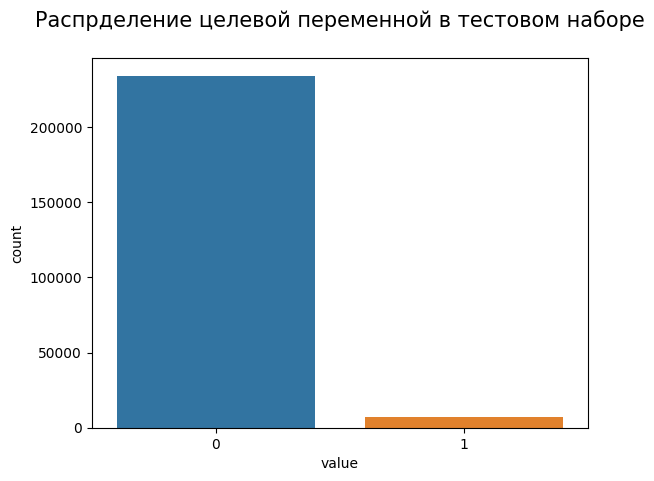

In [130]:
plt.title("Распрделение целевой переменной в тестовом наборе\n",fontsize=15)
sns.countplot(y_test)
plt.xlabel('value', fontsize=10);
plt.show()

In [132]:
print(f"Значение precision на тестовой выборке = {f1_score(y_test_pred, y_test)}\n"
      f"Значение recall на тестовой выборке = {recall_score(y_test_pred, y_test)}\n"
      f"Значение roc_auc на тестовой выборке = {roc_auc_score(y_test_pred, y_test)}")

Значение precision на тестовой выборке = 0.0008217701124766386
Значение recall на тестовой выборке = 0.42857142857142855
Значение roc_auc на тестовой выборке = 0.7001539171195442


<font size=4><b> Посмотрим на топ-10 признаков, которые внесли наибольший вклад в получение моделью предсказаний:

In [134]:
# Feature importance
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.round(best_rf.feature_importances_, 3)
})

importances.sort_values("importance", ascending=False)[:10]

,feature,importance
29,mean_mcc_category_2,0.020
125,days_before_median,0.020
64,mean_day_of_week_2,0.020
120,hour_diff_median,0.019
118,hour_diff_max,0.018
28,mean_mcc_category_1,0.018
121,hour_diff_var,0.017
117,amnt_std,0.017
114,amnt_mean,0.017
68,mean_day_of_week_6,0.016


In [137]:
def plot_fi(fi):
    return fi.sort_values("importance", ascending=False)[:25].plot('feature', 'importance', 'barh', figsize=(12, 7), legend=False)

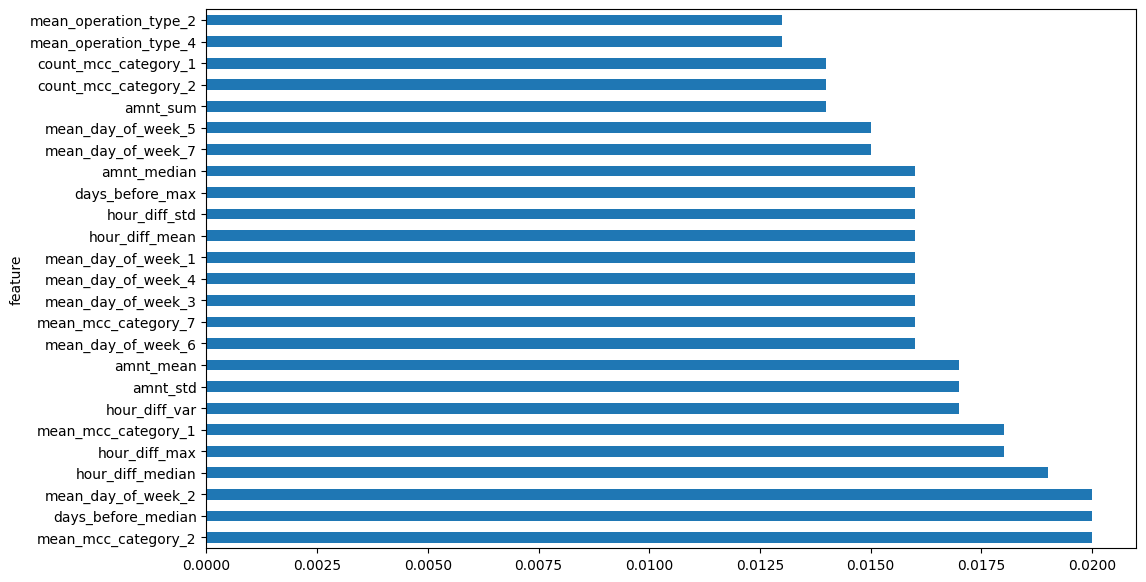

In [138]:
plot_fi(importances);